# EECS 491: Probabilistic Graphical Models Assignment 2
**David Fan**

3/7/18

# Exercise 3

## Problem Description
In this problem we will imitate the Image Denoising example from class and use Markov Random Fields to remove noise from a binary image. We will describe the image as an array of binary pixel values $y_i \in \{-1, 1\}$, where the index $i = 1,...,D$ runs over all of the pixels. The noisy image will be created by taking a noise free binary image, and randomly flipping its pixel values with some low probability.

## Preprocessing
First we need to load in our image and add noise. The image will be loaded using [scikit-image](http://scikit-image.org/). Scikit-image's `imread()` function allows for greyscale importing. Noise will be applied using the method described above. Pixels will be flipped with a 15% probability.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from scipy.signal import convolve2d as conv2d

Here an extra preprocessing step was actually needed. The "binary" image I found online [here](https://www.quora.com/What-is-the-difference-between-a-binary-image-and-a-gray-scale-image) actually wasn't truly binary. This was easily fixed by colormapping the image to greyscale, then looping through each pixel and setting it to 1 if $value \geq .5$ or to -1 if $value < .5$.

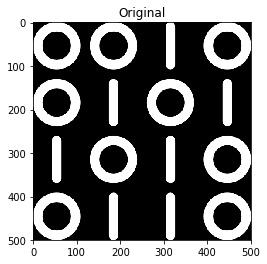

In [15]:
original_image = io.imread('imgs/binary_image.png', as_grey=True)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Original')
ax.imshow(original_image, cmap='gray');

In [23]:
binary_image = np.zeros_like(original_image)
rows, cols = original_image.shape
for r in range(rows):
    for c in range(cols):
        if original_image[r][c] >= .5:
            binary_image[r][c] = 1
        elif original_image[r][c] < .5:
            binary_image[r][c] = -1

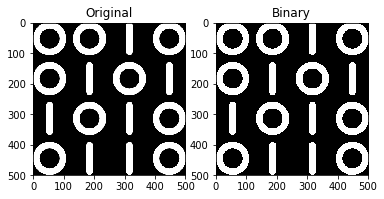

In [25]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_title('Original')
ax.imshow(original_image, cmap='gray');
ax2 = fig.add_subplot(122)
ax2.set_title('Binary')
ax2.imshow(binary_image, cmap='gray');

It's pretty hard to tell without blowing up the images, but the binary image lacks the smooth curves of the original. It seems that the original image was using near blacks to create a smooth effect.

In [38]:
noisy_image = binary_image.copy()
index = np.random.rand(*noisy_image.shape)
noisy_image[index < .15] *= -1

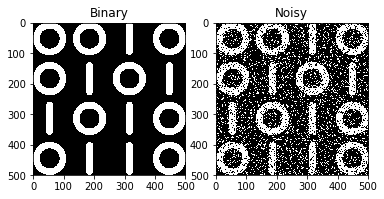

In [39]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_title('Binary')
ax.imshow(binary_image, cmap='gray');
ax2 = fig.add_subplot(122)
ax2.set_title('Noisy')
ax2.imshow(noisy_image, cmap='gray');

## Markov Random Field Model for Image Denoising
We shall now use a Markov Random Field Model to denoise the image. The Markov random field model for images has two types of cliques, one of type $\{x_i, y_i\}$ and another of type $\{x_i, x_j\}$ where i and j are the indicies of neighboring pixels. Similarly to the Image Denoising example discussed in class we shall choose an energy function given by $-\eta x_ix_j$ for cliques of type $\{x_i, y_i\}$ where $\eta$ is a positive constant and $-\beta x_ix_j$ for cliques of type $\{x_i, x_j\}$ where $\beta$ is a positive constant. These energy functions will result in low energy when the pair have the same sign and high energy when the pair have opposite signs.

As in the Image Denoising example, we will add an extra term $\alpha x_i$ for each pixel $i$ in the noise-free image to bias the model towards pixel values that have one particular sign in preference to the other.

Our complete energy function is then:

$$E(X, Y) = \alpha \sum_i x_i - \beta \sum_{i,j}x_ix_j - \eta \sum_ix_iy_i$$

and the joint distribution over x and y is given by:

$$p(x,y) = \frac{1}{Z}exp\{-E(x,y)\}$$

We shall now use gradient descent to update the noisy image to decrease its energy.

In [40]:
def denoise(noisy_image, energy_function):
    recovered_image = noisy_image.copy()
    E,dE = energy_function(recovered_image, noisy_image)
    Etmp, i = E + 1, 0
    while Etmp > E:
        Etmp = E
        recovered_image[dE < 0] *= -1
        [E, dE] = energy_function(recovered_image, noisy_image)
        i += 1
    recovered_image[recovered_image == -1] = 0
    return recovered_image

## Energy Function
Let us define a neighborhood function $N(\cdot)$ to refer to connected pixels as in the Image Denoising example. We shall refer to the four pixels returned by the neighborhood function as $\{N_j(\cdot),j \in [1,2,3,4]\}$.

The energy function then becomes:

$$E(X,Y) = \alpha \sum_i x_i - \beta \sum{i,j}x_iN_j(x_i) - \eta \sum_i x_iy_i$$

Let us define an image $X'$ as equivalent to image $X$ but with pixel $x_k$'s value flipped. The energy of $X'$ is:

$$
\begin{array}{lll}
    E(X',Y) & = &  \alpha (\sum\limits_{i} x_i - 2 x_k) - \beta (\sum\limits_{i,j} x_i N_j(x_i) - \sum\limits_{j} 2 x_k N_j(x_k)) - \eta (\sum\limits_{i} x_i y_i - 2 x_k y_k) \\
            & = &  E(X,Y) - 2 x_k ( \alpha - \beta \sum\limits_{j} N_j(x_k) - \eta y_k) 
\end{array}
$$

and $\Delta E$ is:

$$ \Delta E =  - 2 x_k ( \alpha - \beta \sum\limits_{j} N_j(x_k) - \eta y_k)$$

Now we will use convolutions to calculate $\beta$

In [41]:
def defaultEnergyFunction(hidden, observation, alpha=1, beta=1, eta=1):
    Tb = np.asarray([[0,1.0,0], [1.0,0,1.0], [0, 1.0, 0]])
    matB = conv2d(hidden, Tb, 'same')
    mapE = hidden * (alpha - beta * matB - eta * observation)
    E = np.mean(mapE)
    dE = -2 * mapE
    
    return E, dE

In [44]:
recovered_image = denoise(noisy_image, defaultEnergyFunction)

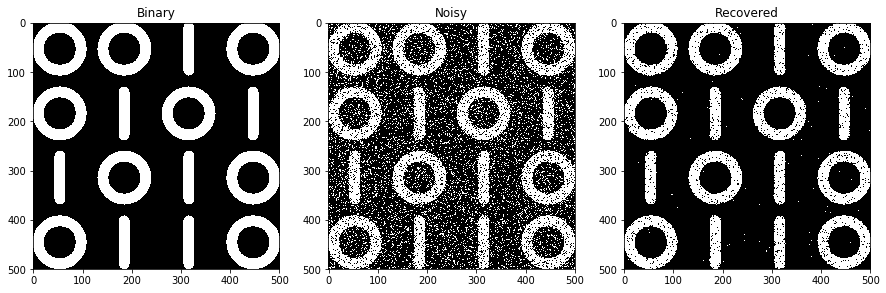

In [48]:
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(131)
ax.set_title('Binary')
ax.imshow(binary_image, cmap='gray');
ax2 = fig.add_subplot(132)
ax2.set_title('Noisy')
ax2.imshow(noisy_image, cmap='gray');
ax3 = fig.add_subplot(133)
ax3.set_title('Recovered')
ax3.imshow(recovered_image, cmap='gray');

As we can see, the recovered image is quite good! Let's see what happens when significantly more noise is added than 15%.

## More Noise...

In [63]:
super_noisy_image = binary_image.copy()
index = np.random.rand(*super_noisy_image.shape)
super_noisy_image[index < .25] *= -1

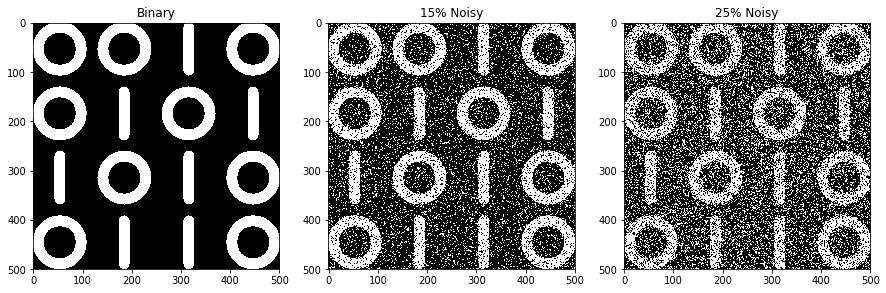

In [64]:
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(131)
ax.set_title('Binary')
ax.imshow(binary_image, cmap='gray');
ax2 = fig.add_subplot(132)
ax2.set_title('15% Noisy')
ax2.imshow(noisy_image, cmap='gray');
ax3 = fig.add_subplot(133)
ax3.set_title('25% Noisy')
ax3.imshow(super_noisy_image, cmap='gray');

In [65]:
super_recovered_image = denoise(super_noisy_image, defaultEnergyFunction)

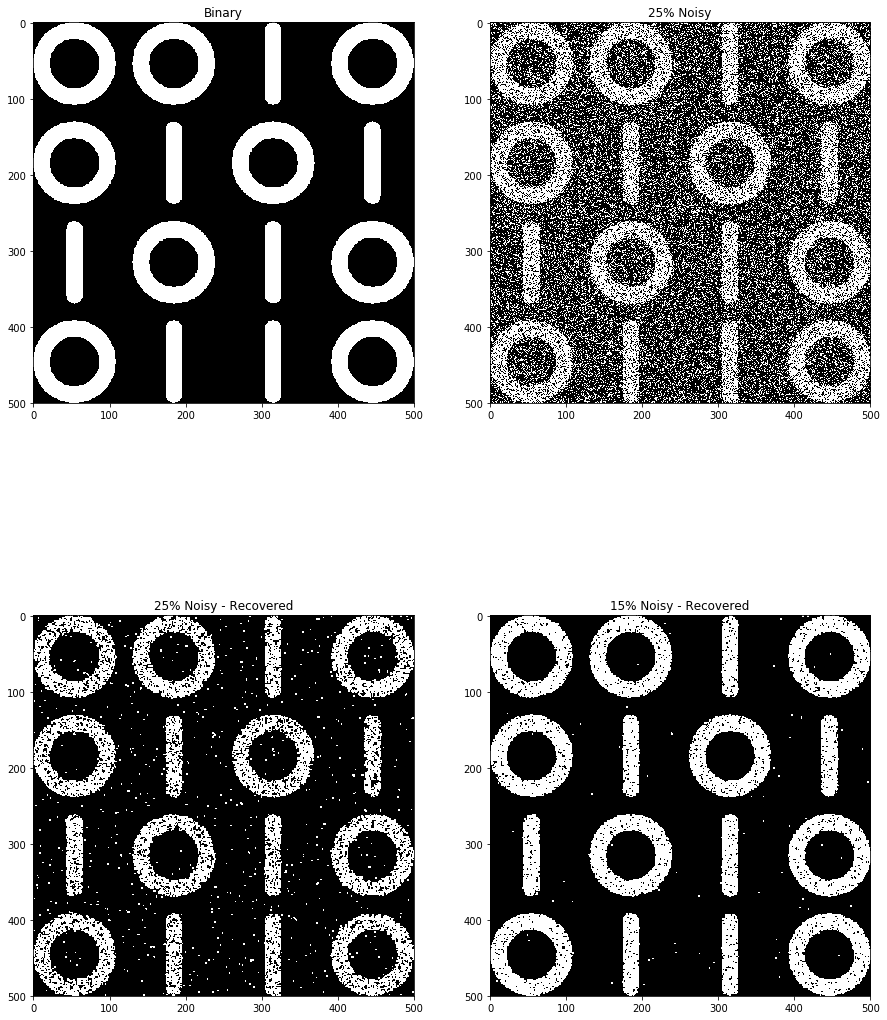

In [66]:
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(221)
ax.set_title('Binary')
ax.imshow(binary_image, cmap='gray');
ax2 = fig.add_subplot(222)
ax2.set_title('25% Noisy')
ax2.imshow(super_noisy_image, cmap='gray');
ax3 = fig.add_subplot(223)
ax3.set_title('25% Noisy - Recovered')
ax3.imshow(super_recovered_image, cmap='gray');
ax4 = fig.add_subplot(224)
ax4.set_title('15% Noisy - Recovered')
ax4.imshow(recovered_image, cmap='gray');

It is now considerably worse, but it is still quite clear what the original image was despite some noise. Let us see how much noise it takes until our process is no longer effective in recovering something that is close to our original image.

In [67]:
really_noisy_image = binary_image.copy()
index = np.random.rand(*really_noisy_image.shape)
really_noisy_image[index < .40] *= -1

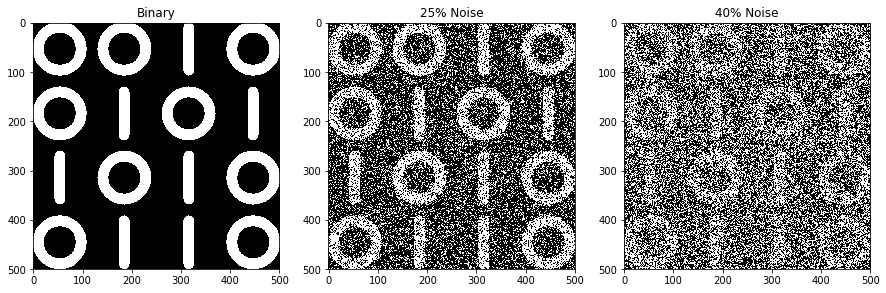

In [68]:
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(131)
ax.set_title('Binary')
ax.imshow(binary_image, cmap='gray');
ax2 = fig.add_subplot(132)
ax2.set_title('25% Noise')
ax2.imshow(super_noisy_image, cmap='gray');
ax3 = fig.add_subplot(133)
ax3.set_title('40% Noise')
ax3.imshow(really_noisy_image, cmap='gray');

With 40% noise applied, it is very difficult to tell what the original image was. Let's see how well the model does with removing the noise.

In [69]:
really_recovered_image = denoise(really_noisy_image, defaultEnergyFunction)

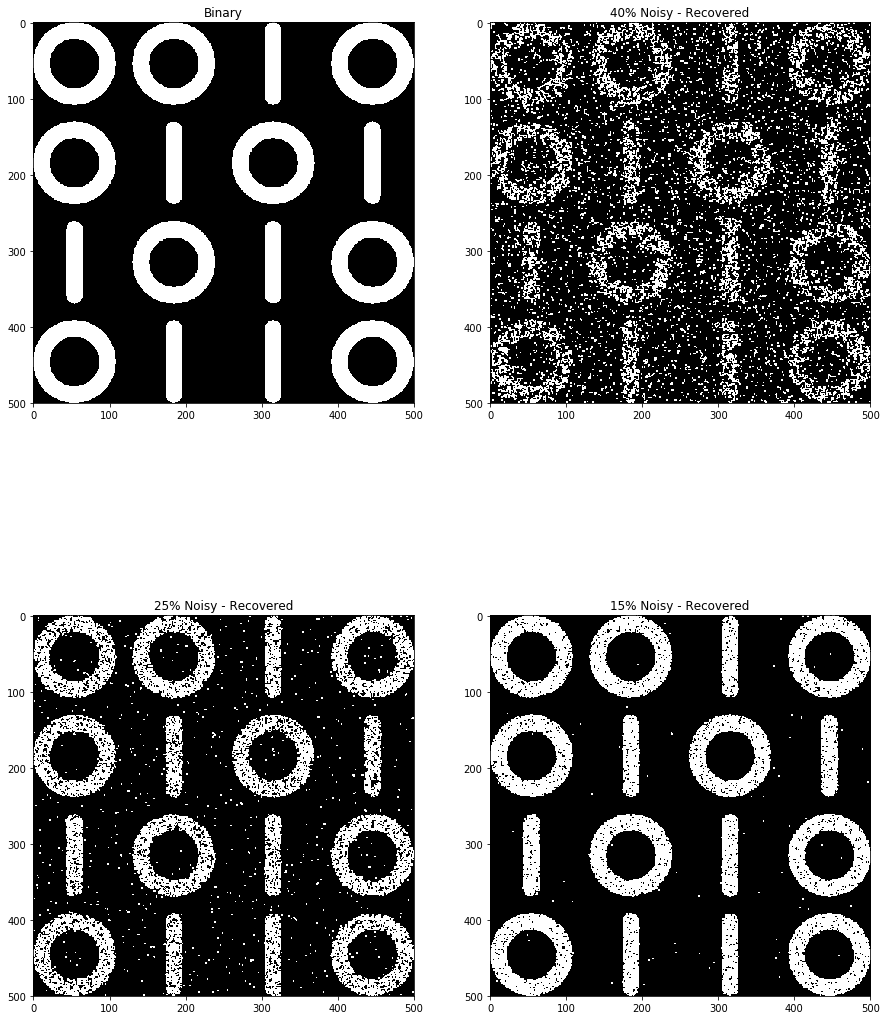

In [80]:
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(221)
ax.set_title('Binary')
ax.imshow(binary_image, cmap='gray');
ax2 = fig.add_subplot(222)
ax2.set_title('40% Noisy - Recovered')
ax2.imshow(really_recovered_image, cmap='gray');
ax3 = fig.add_subplot(223)
ax3.set_title('25% Noisy - Recovered')
ax3.imshow(super_recovered_image, cmap='gray');
ax4 = fig.add_subplot(224)
ax4.set_title('15% Noisy - Recovered')
ax4.imshow(recovered_image, cmap='gray');

The recovered image from the 40% noisy image is beginning to lose original shape and clarity. It makes sense that the performance of the model degrades heavily as more noise is added as it is built on the assumption that there is low noise so there is high correlation between neighboring pixels.